# 03 - Masking Strategies Testing

This notebook visualizes the different masking strategies used in JEPA:
1. **Random Masking** — uniformly random patch selection
2. **Block Masking** — contiguous rectangular blocks (I-JEPA style)
3. **Anatomy-Aware Masking** — saliency-biased sampling of target patches
4. **3D Block Masking** — cuboid masking for volumetric data (V-JEPA)

In [1]:
# Cell 1: Setup
import sys
sys.path.append("..")

from medjepa.data.masking import PatchMasker2D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

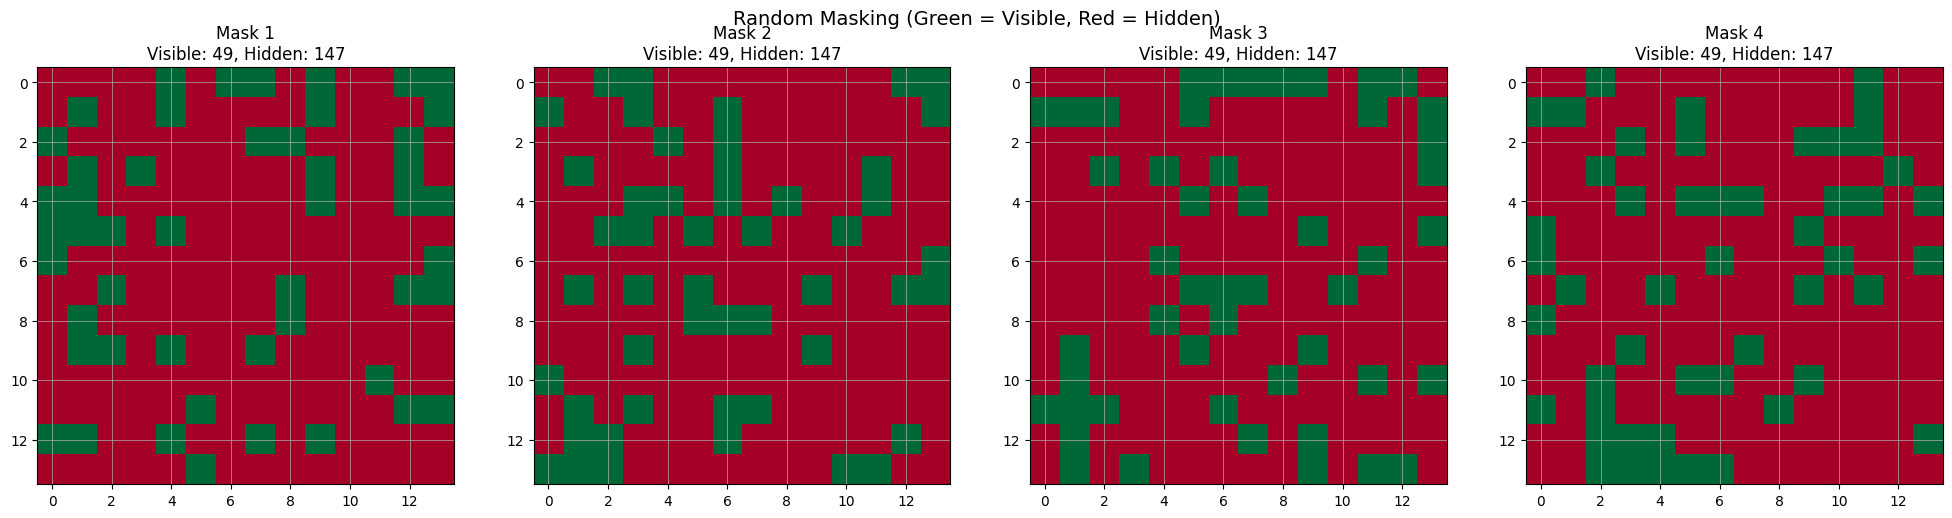

In [2]:
# Cell 2: Test random masking
masker = PatchMasker2D(image_size=224, patch_size=16, mask_ratio=0.75)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ctx, tgt = masker.generate_mask()
    grid = masker.visualize_mask(ctx, tgt)
    axes[i].imshow(grid, cmap="RdYlGn_r", vmin=0, vmax=1)
    axes[i].set_title(f"Mask {i+1}\nVisible: {len(ctx)}, Hidden: {len(tgt)}")
    axes[i].grid(True, linewidth=0.5)

plt.suptitle("Random Masking (Green = Visible, Red = Hidden)", fontsize=14)
plt.tight_layout()
plt.show()

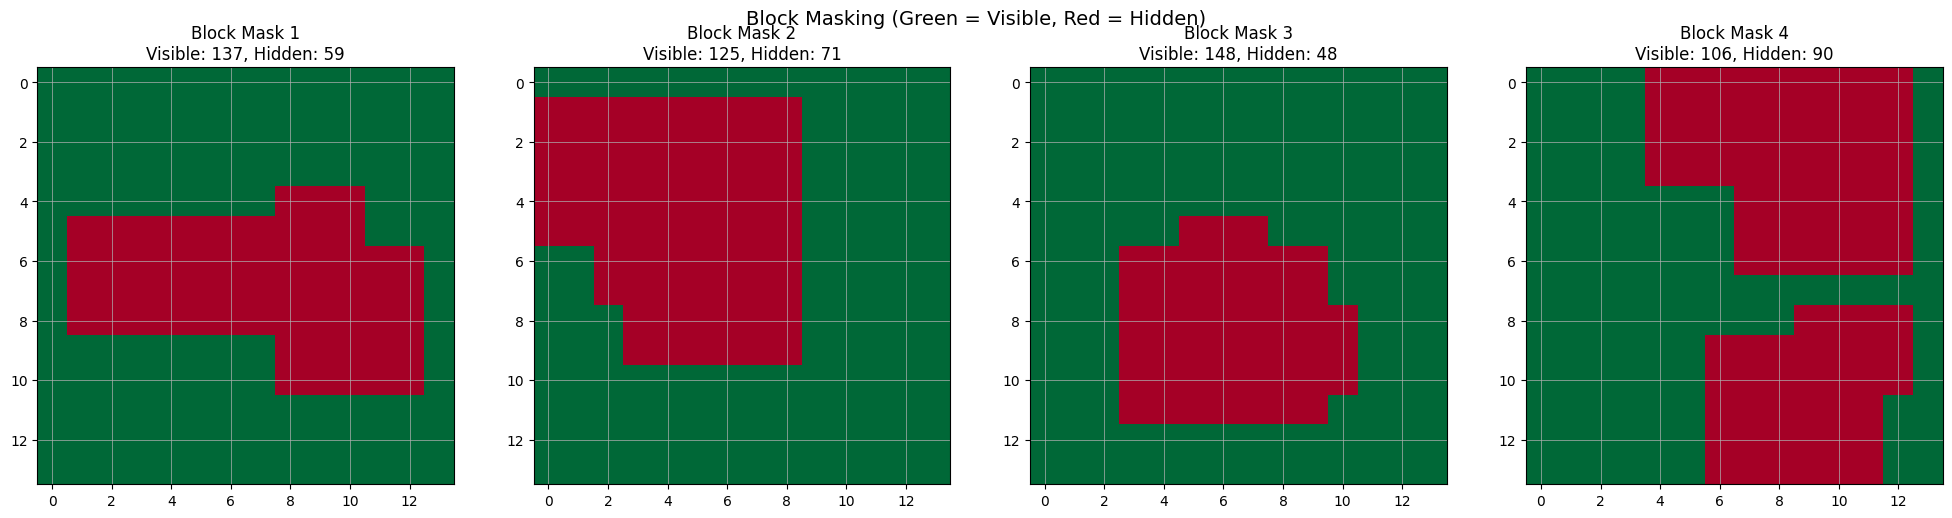

In [3]:
# Cell 3: Test block masking (like I-JEPA)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ctx, tgt = masker.generate_block_mask()
    grid = masker.visualize_mask(ctx, tgt)
    axes[i].imshow(grid, cmap="RdYlGn_r", vmin=0, vmax=1)
    axes[i].set_title(f"Block Mask {i+1}\nVisible: {len(ctx)}, Hidden: {len(tgt)}")
    axes[i].grid(True, linewidth=0.5)

plt.suptitle("Block Masking (Green = Visible, Red = Hidden)", fontsize=14)
plt.tight_layout()
plt.show()

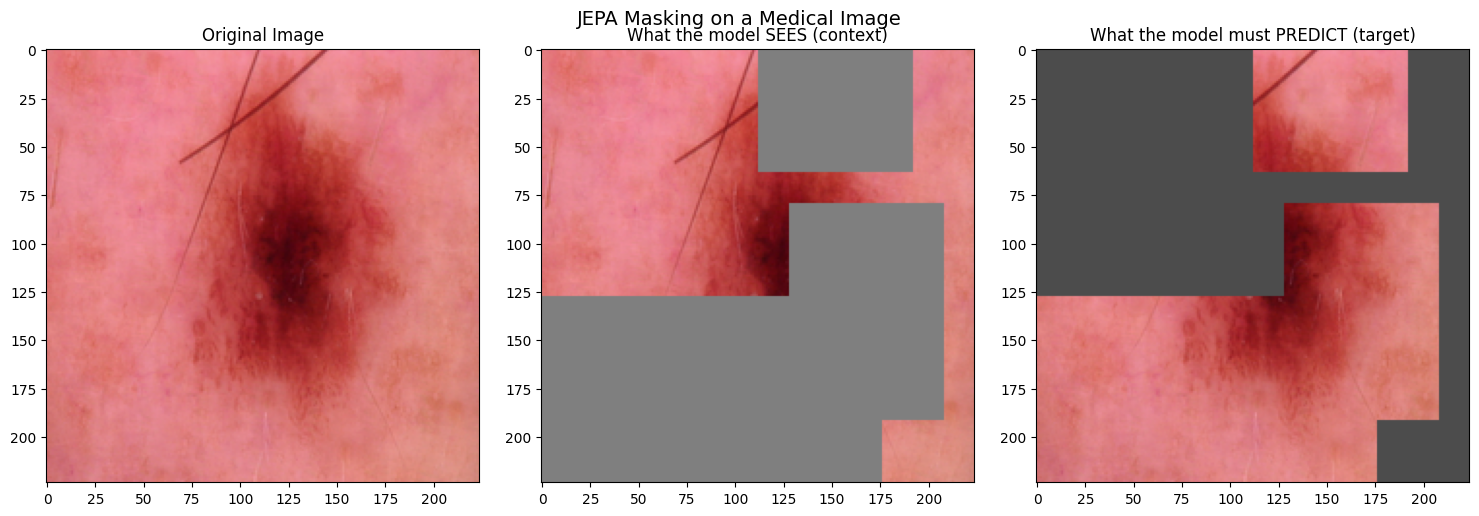

In [4]:
# Cell 4: Show masking on a real medical image
from medjepa.data.preprocessing import MedicalImagePreprocessor
from pathlib import Path

preprocessor = MedicalImagePreprocessor(target_size=(224, 224))

# Load a sample image (use any image you have)
sample_images = list(Path("../data/raw/ham10000").rglob("*.jpg"))
if sample_images:
    img = preprocessor.preprocess(str(sample_images[0]))

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original
    axes[0].imshow(img)
    axes[0].set_title("Original Image")

    # Apply mask visually
    ctx, tgt = masker.generate_block_mask()
    mask_grid = masker.visualize_mask(ctx, tgt)

    # Create masked version
    masked_img = img.copy()
    patch_size = 16
    for patch_idx in tgt.numpy():
        row = (patch_idx // 14) * patch_size
        col = (patch_idx % 14) * patch_size
        masked_img[row:row+patch_size, col:col+patch_size] = 0.5  # Gray out

    axes[1].imshow(masked_img)
    axes[1].set_title("What the model SEES (context)")

    # Show target regions
    target_img = np.ones_like(img) * 0.3
    for patch_idx in tgt.numpy():
        row = (patch_idx // 14) * patch_size
        col = (patch_idx % 14) * patch_size
        target_img[row:row+patch_size, col:col+patch_size] = img[row:row+patch_size, col:col+patch_size]

    axes[2].imshow(target_img)
    axes[2].set_title("What the model must PREDICT (target)")

    plt.suptitle("JEPA Masking on a Medical Image", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# Cell 5: 3D Volumetric Masking (PatchMasker3D)
from medjepa.data.masking import PatchMasker3D

masker_3d = PatchMasker3D(
    volume_size=(128, 128, 64),
    patch_size=(16, 16, 8),
    mask_ratio=0.75,
)

print(f"3D Grid: {masker_3d.grid_size} = {masker_3d.num_patches} total patches")

# Visualize 3D mask as slices through the volume grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for trial in range(2):
    ctx_3d, tgt_3d = masker_3d.generate_mask()
    print(f"Trial {trial+1}: visible={len(ctx_3d)}, hidden={len(tgt_3d)}")

    # Reconstruct 3D mask grid
    gD, gH, gW = masker_3d.grid_size
    mask_vol = np.zeros(masker_3d.num_patches)
    mask_vol[tgt_3d.numpy()] = 1
    mask_vol = mask_vol.reshape(gD, gH, gW)

    # Show 4 depth slices through the mask grid
    depth_indices = np.linspace(0, gD-1, 4, dtype=int)
    for i, di in enumerate(depth_indices):
        axes[trial][i].imshow(mask_vol[di], cmap="RdYlGn_r", vmin=0, vmax=1)
        axes[trial][i].set_title(f"Depth {di}/{gD-1}")
        axes[trial][i].grid(True, linewidth=0.5)

plt.suptitle("3D Volumetric Masking (Green=Visible, Red=Hidden)\nEach image = one depth slice of the 3D patch grid", fontsize=13)
plt.tight_layout()
plt.show()

In [ ]:
# Cell 6: Temporal Masking (for video/sequences)
from medjepa.data.masking import TemporalMasker

temporal_masker = TemporalMasker(
    num_frames=16,
    patch_size_spatial=16,
    image_size=224,
    mask_ratio_temporal=0.5,
    mask_ratio_spatial=0.75,
)

print("Temporal masking — hides entire frames + spatial patches:")
for trial in range(3):
    result = temporal_masker.generate_mask()
    visible_f = result["visible_frames"].tolist()
    hidden_f = result["hidden_frames"].tolist()
    visible_p = len(result["visible_patches"])
    total_sp = temporal_masker.num_spatial_patches
    print(f"  Trial {trial+1}: visible frames {visible_f}, hidden frames {hidden_f}")
    print(f"           spatial: {visible_p}/{total_sp} patches visible per frame")

print("\nThis is used for cardiac MRI sequences and surgical video.")